In [1]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

from lanczos_bin import *

from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

# Lanczos approx and bounds

Want to illustrate:
- average lanczos bounds over samples

In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
n = 1000

lam = np.hstack([
    np.linspace(0,1,n-n//5-n//5-n//20),
    np.linspace(3,4,n//5),
    np.linspace(5,8,n//5),
    np.linspace(15.8,16,n//20),
])

lam += np.random.randn(n)/10
#lam = np.load('matrices/California_SVD.npy').flatten()
#n = len(lam)

lam = np.sort(lam)

lam /= np.max(lam)

A = sp.sparse.spdiags(lam,0,n,n)

In [4]:
# define CESM and averaged wCESM
CESM = Distribution()
CESM.from_weights(lam,np.ones(n)/n)

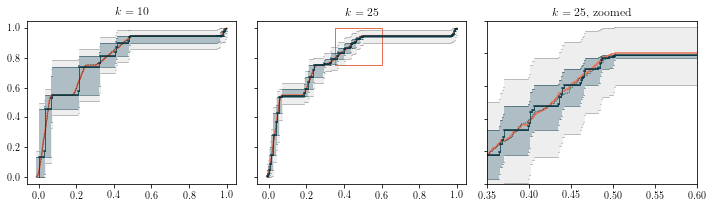

In [5]:
eta = .01
n_samples = 7
eps = np.sqrt( (n+2)**(-1) * n_samples**(-1) * np.log(2*n/(eta)) )

fig,axs = plt.subplots(1,3,figsize=(12,3))
fig.subplots_adjust(wspace=.1)

for i,k in enumerate([10,25,25]):
    
    np.random.seed(9) # for reproducibility

    lb,ub = np.min(lam),np.max(lam)
    GQ = []
    GQ_upper = []
    GQ_lower = []

    v2_ave = np.zeros(n)

    for J in range(n_samples):

        v = np.random.randn(n)
        v /= np.linalg.norm(v)

        v2_ave += v**2

        Q,(a_,b_) = exact_lanczos(A,v,k,reorth=True)

        # define Gaussian quadrature
        GQ.append(get_GQ_distr(a_[:k],b_[:k-1]))

        # define upper and lower bounds
        GQ_lower.append(get_GQ_lower_bound(GQ[-1],lb,ub))
        GQ_upper.append(get_GQ_upper_bound(GQ[-1],lb,ub))

    v2_ave /= n_samples

    wCESM_ave = Distribution()
    wCESM_ave.from_weights(lam,v2_ave)

    # average bounds
    GQ_ave = get_ave_distr(GQ)
    GQ_lower_ave = get_ave_distr(GQ_lower)
    GQ_upper_ave = get_ave_distr(GQ_upper)

    # average bounds + eps
    GQ_lower_ave_eps = add_constant(GQ_lower_ave,-eps,lb,ub)
    GQ_upper_ave_eps = add_constant(GQ_upper_ave,eps,lb,ub)

    
    axs[i].fill_between(GQ_lower_ave_eps.support,\
                     GQ_lower_ave_eps.distr,\
                     GQ_upper_ave_eps.distr,\
                     step='post',color='#eeeeee')
    step, = mystep(*GQ_lower_ave_eps.get_distr(),ax=axs[i],where='post',ls='-',lw=.5,color='#888888')
    step, = mystep(*GQ_upper_ave_eps.get_distr(),ax=axs[i],where='post',ls='-',lw=.5,color='#888888')
    
    axs[i].fill_between(GQ_lower_ave.support,\
                     GQ_lower_ave.distr,\
                     GQ_upper_ave.distr,\
                     step='post',facecolor='#afbec4')
    step, = mystep(*GQ_lower_ave.get_distr(),ax=axs[i],where='post',ls='-',lw=.5,color='#073642')
    step, = mystep(*GQ_upper_ave.get_distr(),ax=axs[i],where='post',ls='-',lw=.5,color='#073642')

    axs[i].step(*CESM.get_distr(),where='post',linestyle='-',color='#E76F51')

    axs[i].step(*wCESM_ave.get_distr(),where='post',linestyle='--',lw=.5,color='#073642')

    axs[i].step(*GQ_ave.get_distr(),where='post',lw='.75',color='#073642')
    step, = mystep(*GQ_ave.get_distr(),ax=axs[i],where='post',color='#073642')

    axs[i].set_title(f'$k={k}$')


axs[0].get_shared_x_axes().join(axs[0], axs[1])
axs[1].set_yticklabels([])
axs[2].set_yticklabels([])

# Create a Rectangle patch
x1,x2,y1,y2 = .35,.6,.75,1

rect = mpatches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor='#E76F51',facecolor='none')

# Add the patch to the Axes
axs[1].add_patch(rect)

axs[2].set_xlim(x1,x2)
axs[2].set_ylim(y1,y2)
axs[2].set_title(f'$k={k}$, zoomed')

legend_elements = [
                   Line2D([0],[0],linestyle='-',color='#E76F51',label=r'$\Phi = \Phi(\vec{A})$'),
                   Line2D([0],[0],linestyle='-',lw=.5,color='#073642',label=r'$\langle\Psi_i\rangle = \langle\Psi(\vec{A},\vec{v}_i)\rangle$'),
                   Line2D([0],[0],linestyle='-',color='#073642',label=r'$\langle\textsf{gq}_k(\Psi_i)\rangle$'),
                   mpatches.Patch(facecolor='#afbec4',edgecolor='#073642',linewidth=.5,label=r'$\langle\textsf{gq}_k^{\downarrow}(\Psi_i)\rangle$, $\langle\textsf{gq}_k^{\uparrow}(\Psi_i)\rangle$'),
                   mpatches.Patch(facecolor='#eeeeee',edgecolor='#888888',linewidth=.5,label=r'$\langle\textsf{gq}_k^{\downarrow}(\Psi_i)\rangle-t$, $\langle\textsf{gq}_k^{\uparrow}(\Psi_i)\rangle+t$')
]

#axs[0].legend(handles=legend_elements,loc='lower right')
#axs[0].set_title(f'$n_v={n_samples}$ ($\eta = {eta}$, $t = {eps}$, $n={n}$)')

plt.savefig('imgs/CESM_bounds.pdf',bbox_inches='tight')